In [1]:
import jax.numpy as jnp
import genjax
import numpy as np
import jax
import b3d
from b3d.pose import Pose
from carvekit.api.high import HiInterface
from b3d.utils import VideoInput
from tqdm import tqdm
import genjax
import os
import rerun as rr
from jax_gl_renderer import JaxGLRenderer
from dcolmap.hgps.pose_grids import uniform_samples_from_SE3_around_identity
import matplotlib.pyplot as plt
from typing import Any
from genjax.generative_functions.distributions import ExactDensity
from tensorflow_probability.substrates import jax as tfp
from jax.scipy.stats import norm
import cv2
import genjax
from jax.scipy.special import logsumexp
import rerun as rr

import torch
from carvekit.api.high import HiInterface

from dcolmap.hgps.model import model_gl_factory_debug, rerun_visualize_trace_t



In [2]:
## setup rerun
rr.init("BUNNY")
rr.connect(addr=f'127.0.0.1:{8802}')

[2024-03-27T04:30:09Z WARN  re_sdk_comms::buffered_client] Failed to send message after 3 attempts: Failed to connect to Rerun server at 127.0.0.1:8802: Connection refused (os error 111)
[2024-03-27T04:30:11Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-03-27T04:30:11Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-03-27T04:30:11Z WARN  re_sdk_comms::tcp_client] Tried to flush while TCP stream was still Pending. Data was possibly dropped.


In [3]:
## process input video
path = os.path.join(b3d.get_assets_path(), "shared_data_bucket/input_data/ramen_case.r3d.video_input.npz")
video_input = VideoInput.load(path) 

image_width, image_height, fx,fy, cx,cy,near,far = np.array(video_input.camera_intrinsics_depth)
image_width, image_height = int(image_width), int(image_height)
fx,fy,cx,cy,near,far = float(fx),float(fy), float(cx),float(cy),float(near),float(far)

rgbs = video_input.rgb / 255.0
depths_observed = video_input.xyz
# Resize rgbs to be same size as depth.
rgbs_resized = jnp.clip(jax.vmap(jax.image.resize, in_axes=(0, None, None))(
    rgbs, (video_input.xyz.shape[1], video_input.xyz.shape[2], 3), "linear"
), 0.0, 1.0)

# Get camera poses.
camera_poses = jax.vmap(lambda x,y: Pose(x,y), in_axes=(0,0))(
    video_input.camera_positions,
    video_input.camera_quaternions
)

In [4]:
T = 0

0.0 1.0


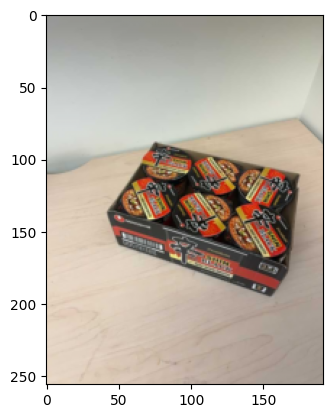

: 

In [21]:
print(rgbs_resized.min(), rgbs_resized.max())
plt.imshow(rgbs_resized[T])

In [6]:
## segment and acquire mesh for frame

interface = HiInterface(object_type="hairs-like",  # Can be "object" or "hairs-like".
                        batch_size_seg=5,
                        batch_size_matting=1,
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        seg_mask_size=640,  # Use 640 for Tracer B7 and 320 for U2Net
                        matting_mask_size=2048,
                        trimap_prob_threshold=231,
                        trimap_dilation=30,
                        trimap_erosion_iters=5,
                        fp16=False)

output_images = interface([b3d.get_rgb_pil_image(rgbs_resized[T])])
mask  = jnp.array([jnp.array(output_image)[..., -1] > 0.5 for output_image in output_images])[0]

rr.log("/img", rr.Image(jnp.clip(rgbs_resized[T], 0.0, 1.0)))
# rr.log("/img/mask", rr.Image(jnp.tile((mask * 1.0)[...,None],(1,1,3))))

xyz = video_input.xyz[T]
point_cloud_for_mesh = xyz[mask]
colors_for_mesh = rgbs_resized[T][mask]

_vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud_for_mesh, colors_for_mesh, point_cloud_for_mesh[:,2] / fx
)

object_pose = Pose.from_translation(_vertices.mean(0))  # CAMERA frame object pose
vertices = object_pose.inverse().apply(_vertices)  # WORLD frame vertices

rr.log(
    "/3d/mesh",
    rr.Mesh3D(
        vertex_positions=_vertices,
        indices=faces,
        vertex_colors=vertex_colors
    ),
    timeless=True
)    

In [7]:
## load data that shows same color but diff brightness, etc
renderer = JaxGLRenderer(image_width, image_height, fx, fy, cx, cy, near, far)
model_template_fn = jax.tree_util.Partial(model_gl_factory_debug, renderer)

# model(        
#     color_obsrvation_model_custom,
#     vertices,
#     faces,
#     colors,
#     space_error,
#     inlier_score,
#     multiplier)

## Color spaces
wiki list https://en.wikipedia.org/wiki/Color_space

https://www.mathworks.com/help/images/understanding-color-spaces-and-color-space-conversion.html

#### Error functions

In [8]:
##########
# L2
##########

def likelihood_factory_l2_error(rgb_to_color_fn):
    def alternate_likelihood_intermediate_computation(observed_color, rendered_color, colorspace_errors, inlier_score, outlier_prob):
        valid_data_mask = (rendered_color.sum(-1) != 0.0)
        color1 = rgb_to_color_fn(observed_color)
        color2 = rgb_to_color_fn(rendered_color)
        inlier_match_mask = (jnp.linalg.norm(color1 - color2, axis=-1) < colorspace_errors)
        inlier_match_mask = inlier_match_mask * valid_data_mask
        # inlier_match_mask = (jnp.abs(lab1[...,1] - lab2[...,1]) < colorspace_errors[0]) * (jnp.abs(lab1[...,2] - lab2[...,2]) < colorspace_errors[1]) * valid_data_mask
        logp_in = jnp.log((1.0 - outlier_prob) * inlier_score + outlier_prob)
        logp_out = jnp.log(outlier_prob)
        logp_no_data = jnp.log(1 / 1.0)

        num_data_points = jnp.size(inlier_match_mask)
        num_inliers = jnp.sum(inlier_match_mask)
        num_no_data = jnp.sum(1.0 - valid_data_mask)
        num_outliers = num_data_points - num_inliers - num_no_data

        # num_inliers / num_data_points * jnp.exp(logp_in) + num_outliers / num_data_points * jnp.exp(logp_out) + num_no_data / num_data_points * jnp.exp(logp_no_data)

        log_sum_of_probs = logsumexp(jnp.array([
            jnp.log(num_inliers) + logp_in,
            jnp.log(num_outliers) + logp_out,
            jnp.log(num_no_data) + logp_no_data
        ]))
        average_log_prob = log_sum_of_probs - jnp.log(num_data_points)

        return (
            valid_data_mask,
            inlier_match_mask,
            (logp_out, logp_in, logp_no_data),
            (num_data_points, num_inliers, num_no_data, num_outliers),
            average_log_prob
        )
    return alternate_likelihood_intermediate_computation


def likelihood_factory_l2_error_no_mask(rgb_to_color_fn):
    def alternate_likelihood_intermediate_computation_no_mask(observed_color, rendered_color, colorspace_errors, inlier_score, outlier_prob):
        valid_data_mask = (rendered_color.sum(-1) != 0.0)
        color1 = rgb_to_color_fn(observed_color)
        color2 = rgb_to_color_fn(rendered_color)
        color_error = jnp.linalg.norm(color1 - color2, axis=-1)
        inlier_match_mask = (color_error < colorspace_errors)
        inlier_match_mask = inlier_match_mask * valid_data_mask
        # inlier_match_mask = (jnp.abs(lab1[...,1] - lab2[...,1]) < colorspace_errors[0]) * (jnp.abs(lab1[...,2] - lab2[...,2]) < colorspace_errors[1]) * valid_data_mask
        logp_in = jnp.log((1.0 - outlier_prob) * inlier_score + outlier_prob)
        logp_out = jnp.log(outlier_prob)
        logp_no_data = jnp.log(1 / 1.0)

        num_data_points = jnp.size(inlier_match_mask)
        num_inliers = jnp.sum(inlier_match_mask)
        num_no_data = jnp.sum(1.0 - valid_data_mask)
        num_outliers = num_data_points - num_inliers - num_no_data

        # num_inliers / num_data_points * jnp.exp(logp_in) + num_outliers / num_data_points * jnp.exp(logp_out) + num_no_data / num_data_points * jnp.exp(logp_no_data)

        log_sum_of_probs = logsumexp(jnp.array([
            jnp.log(num_inliers) + logp_in,
            jnp.log(num_outliers) + logp_out,
            jnp.log(num_no_data) + logp_no_data
        ]))
        average_log_prob = log_sum_of_probs - jnp.log(num_data_points)

        return (
            color_error,
            valid_data_mask,
            inlier_match_mask,
            (logp_out, logp_in, logp_no_data),
            (num_data_points, num_inliers, num_no_data, num_outliers),
            average_log_prob
        )
    return alternate_likelihood_intermediate_computation_no_mask

In [9]:
##########
# CI Error functions
##########

def likelihood_factory_ciede_error():
    def alternate_likelihood_intermediate_computation(observed_color_lab, rendered_color_lab, colorspace_errors, inlier_score, outlier_prob):
        valid_data_mask = (rendered_color_lab.sum(-1) != 0.0)
        color1 = observed_color_lab.reshape((-1,3))
        color2 = rendered_color_lab.reshape((-1,3))
        inlier_match_mask = (b3d.ciede2000_err(color1, color2) < colorspace_errors)
        inlier_match_mask = inlier_match_mask * valid_data_mask
        # inlier_match_mask = (jnp.abs(lab1[...,1] - lab2[...,1]) < colorspace_errors[0]) * (jnp.abs(lab1[...,2] - lab2[...,2]) < colorspace_errors[1]) * valid_data_mask
        logp_in = jnp.log((1.0 - outlier_prob) * inlier_score + outlier_prob)
        logp_out = jnp.log(outlier_prob)
        logp_no_data = jnp.log(1 / 1.0)

        num_data_points = jnp.size(inlier_match_mask)
        num_inliers = jnp.sum(inlier_match_mask)
        num_no_data = jnp.sum(1.0 - valid_data_mask)
        num_outliers = num_data_points - num_inliers - num_no_data

        # num_inliers / num_data_points * jnp.exp(logp_in) + num_outliers / num_data_points * jnp.exp(logp_out) + num_no_data / num_data_points * jnp.exp(logp_no_data)

        log_sum_of_probs = logsumexp(jnp.array([
            jnp.log(num_inliers) + logp_in,
            jnp.log(num_outliers) + logp_out,
            jnp.log(num_no_data) + logp_no_data
        ]))
        average_log_prob = log_sum_of_probs - jnp.log(num_data_points)

        return (
            valid_data_mask,
            inlier_match_mask,
            (logp_out, logp_in, logp_no_data),
            (num_data_points, num_inliers, num_no_data, num_outliers),
            average_log_prob
        )
    return alternate_likelihood_intermediate_computation


def likelihood_factory_ciede_error_no_mask():
    def alternate_likelihood_intermediate_computation_no_mask(observed_color_lab, rendered_color_lab, colorspace_errors, inlier_score, outlier_prob):
        valid_data_mask = (rendered_color_lab.sum(-1) != 0.0)
        h,w,_ = observed_color_lab.shape
        color1 = observed_color_lab.reshape((h*w,3))
        color2 = rendered_color_lab.reshape((h*w,3))
        
        color_error = b3d.ciede2000_err(color1, color2).reshape((h,w))
        inlier_match_mask = (color_error < colorspace_errors)
        inlier_match_mask = inlier_match_mask * valid_data_mask
        # inlier_match_mask = (jnp.abs(lab1[...,1] - lab2[...,1]) < colorspace_errors[0]) * (jnp.abs(lab1[...,2] - lab2[...,2]) < colorspace_errors[1]) * valid_data_mask
        logp_in = jnp.log((1.0 - outlier_prob) * inlier_score + outlier_prob)
        logp_out = jnp.log(outlier_prob)
        logp_no_data = jnp.log(1 / 1.0)

        num_data_points = jnp.size(inlier_match_mask)
        num_inliers = jnp.sum(inlier_match_mask)
        num_no_data = jnp.sum(1.0 - valid_data_mask)
        num_outliers = num_data_points - num_inliers - num_no_data

        # num_inliers / num_data_points * jnp.exp(logp_in) + num_outliers / num_data_points * jnp.exp(logp_out) + num_no_data / num_data_points * jnp.exp(logp_no_data)

        log_sum_of_probs = logsumexp(jnp.array([
            jnp.log(num_inliers) + logp_in,
            jnp.log(num_outliers) + logp_out,
            jnp.log(num_no_data) + logp_no_data
        ]))
        average_log_prob = log_sum_of_probs - jnp.log(num_data_points)

        return (
            color_error,
            valid_data_mask,
            inlier_match_mask,
            (logp_out, logp_in, logp_no_data),
            (num_data_points, num_inliers, num_no_data, num_outliers),
            average_log_prob
        )
    return alternate_likelihood_intermediate_computation_no_mask

### RGB [wiki](https://en.wikipedia.org/wiki/RGB_color_spaces)
<img src="https://upload.wikimedia.org/wikipedia/commons/8/83/RGB_Cube_Show_lowgamma_cutout_b.png" alt="drawing" width="300"/> 

We use 0~1

In [10]:
## RGB

rgb_alternate_likelihood_intermediate_computation = likelihood_factory_l2_error(lambda rgb:rgb) 

class RGBColorObservationModel(ExactDensity,genjax.JAXGenerativeFunction):
    def sample(self, key, rendered_color, colorspace_errors, inlier_score, outlier_prob, multiplier):
        return rendered_color

    def logpdf(self, observed_color, rendered_color, colorspace_errors, inlier_score, outlier_prob, multiplier):
        return rgb_alternate_likelihood_intermediate_computation(
            observed_color, rendered_color, colorspace_errors, inlier_score, outlier_prob
        )[-1] * multiplier

RGB_color_observation_model = RGBColorObservationModel()

RGB_model = model_template_fn(RGB_color_observation_model)

### CIELAB [wiki](https://en.wikipedia.org/wiki/CIELAB_color_space)

In [11]:
## LAB

lab_alternate_likelihood_intermediate_computation = likelihood_factory_l2_error(b3d.rgb_to_lab)

class LABColorObservationModel(ExactDensity,genjax.JAXGenerativeFunction):
    def sample(self, key, rendered_color, colorspace_errors, inlier_score, outlier_prob, multiplier):
        return rendered_color

    def logpdf(self, observed_color, rendered_color, colorspace_errors, inlier_score, outlier_prob, multiplier):
        return lab_alternate_likelihood_intermediate_computation(
            observed_color, rendered_color, colorspace_errors, inlier_score, outlier_prob
        )[-1] * multiplier

LAB_color_observation_model = LABColorObservationModel()

LAB_model = model_template_fn(LAB_color_observation_model)

#### Examine the posterior 
Use gridding + SIR to examine the posterior likelihood around the ground truth

In [12]:
importance_jit = jax.jit(RGB_model.importance); print("RGB")
# importance_jit = jax.jit(LAB_model.importance); print("LAB")

RGB


In [13]:
## params
inlier_score, outlier_prob, multiplier = 4.0, 0.0001, 2000.0
color_error_thresh = 10

In [14]:
def get_score_with_updated_object_pose(trace, key, object_pose):
    return trace.update(key, genjax.choice_map({"object_pose": object_pose}))[0].get_score()
get_score_with_updated_object_pose_parallel = jax.vmap(get_score_with_updated_object_pose, in_axes=(None, None, 0))

@jax.jit
def grid_proposal_object_pose(trace, key):
    ## propose grid and sample from a categorical 
    
    key = jax.random.split(key)[0]
    # delta_poses = uniform_samples_from_SE3_around_identity(key, 2000, rx=0.02, rq=0.04)
    delta_poses = uniform_samples_from_SE3_around_identity(key, 20, rx=0.05, rq=0.08)
    delta_poses = Pose.concatenate_poses([Pose.identity()[None,...], delta_poses])
    test_poses = trace["object_pose"] @ delta_poses
    potential_scores = get_score_with_updated_object_pose_parallel(
        trace, jax.random.PRNGKey(0), test_poses
    )
    samples = jax.random.categorical(jax.random.PRNGKey(10), potential_scores, shape=(100,))
    return test_poses, samples

In [15]:
## initial trace 
trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        {
            "camera_pose": Pose.identity(),
            "object_pose": object_pose,
            "observed_color": rgbs_resized[T],
            "observed_depth":depths_observed[T],
            "outlier_prob": outlier_prob
        }
    ),
    (vertices, faces, vertex_colors, color_error_thresh, inlier_score, multiplier)
)

## get posterior samples
key = jax.random.PRNGKey(0)
test_poses, samples = grid_proposal_object_pose(trace, key)

new_traces = [trace.update(key, genjax.choice_map({"object_pose": test_poses[samples[sample_id]]}))[0] for sample_id in [0,1,2,3,4,5]]


In [16]:
trace_idx = 0  # trace to viz

In [17]:
############
# L2 Loss
#############


## RGB
rgb_viz_thresh = 0.50
(
    color_error_rgb,
    valid_data_mask_rgb,
    inlier_match_mask_rgb,
    (logp_out, logp_in, logp_no_data),
    (num_data_points, num_inliers, num_no_data, num_outliers),
    average_log_prob
) = likelihood_factory_l2_error_no_mask(lambda rgb:rgb)(rgbs_resized[T], # obs color
                                                  new_traces[trace_idx].get_retval()[1], # rendered color
                                                  rgb_viz_thresh * jnp.ones_like(new_traces[trace_idx].get_args()[3]), # error thresh
                                                  *new_traces[trace_idx].get_args()[4:6] # inlier_score, multiplier
                                                )
## LAB
lab_viz_thresh = 40
(
    color_error_lab,
    valid_data_mask,
    inlier_match_mask_lab,
    (logp_out, logp_in, logp_no_data),
    (num_data_points, num_inliers, num_no_data, num_outliers),
    average_log_prob
) = likelihood_factory_l2_error_no_mask(b3d.rgb_to_lab)(rgbs_resized[T], # obs color
                                                  new_traces[trace_idx].get_retval()[1], # rendered color
                                                  lab_viz_thresh * jnp.ones_like(new_traces[trace_idx].get_args()[3]), # error
                                                  *new_traces[trace_idx].get_args()[4:6] # inlier_score, multiplier
                                                )


In [18]:
############
# CIEDE2000 Loss
#############

## LAB
lab_viz_thresh_ciede = 30
(
    color_error_lab_ciede,
    valid_data_mask,
    inlier_match_mask_lab_ciede,
    (logp_out, logp_in, logp_no_data),
    (num_data_points, num_inliers, num_no_data, num_outliers),
    average_log_prob
) = likelihood_factory_ciede_error_no_mask()(b3d.rgb_to_lab(rgbs_resized[T]), # obs color
                                            b3d.rgb_to_lab(new_traces[trace_idx].get_retval()[1]), # rendered color
                                            lab_viz_thresh_ciede * jnp.ones_like(new_traces[trace_idx].get_args()[3]), # error
                                            *new_traces[trace_idx].get_args()[4:6] # inlier_score, multiplier
                                            )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


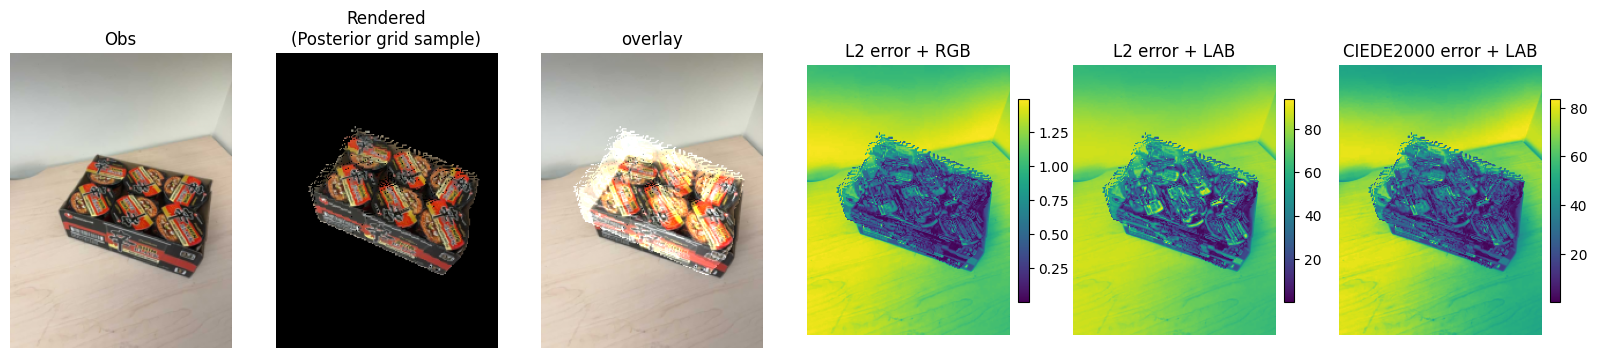

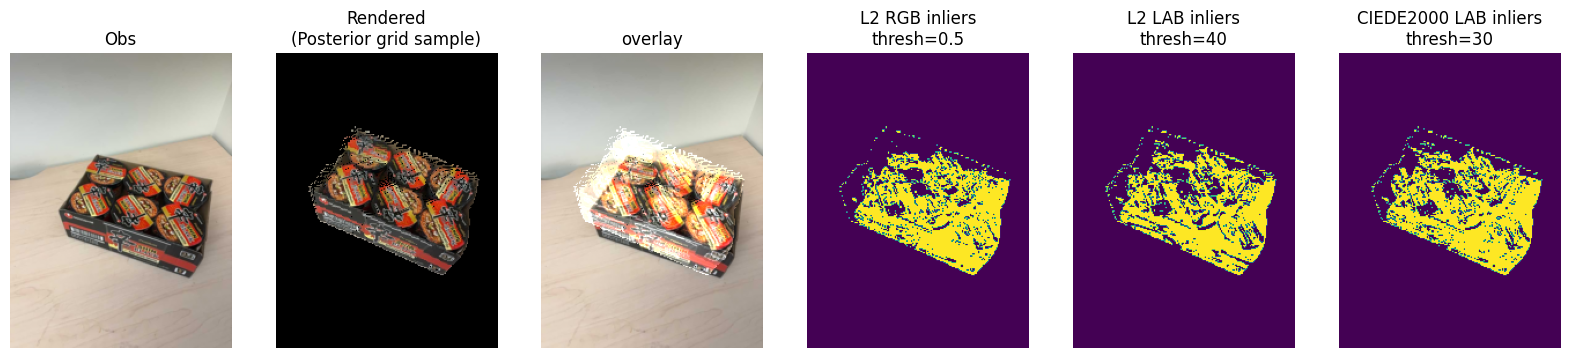

In [19]:
## error values
f2, axes2 = plt.subplots(1,6, figsize=(20,120))
for ax in axes2: ax.axis('off')

axes2[0].imshow(rgbs_resized[T]); 
axes2[1].imshow(new_traces[trace_idx].get_retval()[1]); 
diffheat = axes2[2].imshow(rgbs_resized[T] + new_traces[trace_idx].get_retval()[1]) 
heat1 = axes2[3].imshow(color_error_rgb); f2.colorbar(heat1,fraction=0.046, pad=0.04) # error (rgb)
heat2 = axes2[4].imshow(color_error_lab); f2.colorbar(heat2,fraction=0.046, pad=0.04) # error (lab)
heat1 = axes2[5].imshow(color_error_lab_ciede); f2.colorbar(heat1,fraction=0.046, pad=0.04) # error (rgb)

axes2[0].title.set_text("Obs")
axes2[1].title.set_text("Rendered\n(Posterior grid sample)") 
axes2[2].title.set_text("overlay")
axes2[3].title.set_text(f"L2 error + RGB")
axes2[4].title.set_text(f"L2 error + LAB")
axes2[5].title.set_text(f"CIEDE2000 error + LAB")



# masks
f, axes = plt.subplots(1,6, figsize=(20,120)); 
for ax in axes: ax.axis('off')

axes[0].imshow(rgbs_resized[T]); 
axes[1].imshow(new_traces[trace_idx].get_retval()[1]); 
diffheat = axes[2].imshow(rgbs_resized[T] + new_traces[trace_idx].get_retval()[1]) 
axes[3].imshow(inlier_match_mask_rgb.astype(jnp.int32)); 
axes[4].imshow(inlier_match_mask_lab.astype(jnp.int32)); 
axes[5].imshow(inlier_match_mask_lab_ciede.astype(jnp.int32)); 

axes[0].title.set_text("Obs")
axes[1].title.set_text("Rendered\n(Posterior grid sample)") 
axes[2].title.set_text("overlay")
axes[3].title.set_text(f"L2 RGB inliers\nthresh={rgb_viz_thresh}")
axes[4].title.set_text(f"L2 LAB inliers\nthresh={lab_viz_thresh}")
axes[5].title.set_text(f"CIEDE2000 LAB inliers\nthresh={lab_viz_thresh_ciede}")
